# Bayesian analusis of performance 

This notebook reevaluates the performance of a binary classifier by using the Bayes rule. As an example, we'll use the performance of lie detectors that are being proposed to perform massive screening of migrants and/or refugees.

Although the scientific consensus is that lie detectors does not exits, in this post we do not discuss this issue. Rather we analyse the effect of using this technology, even if it worked, to improve security.

## Quick introduction 

Addapted from [1]:
- **Tests are not the event**. A test for detecting lying is a separate event from actually lying. 
- **Tests are flawed**. Tests detect things that don’t exist (false positive), and miss things that do exist (false negative). People often use test results without adjusting for test errors.
- **Bayes’ theorem** converts the results from your test into the real probability of the event so you can correct the errors estimation or relate the actual probability to the measures test probability.

## Summary of a test

A test is a method to detect events such as cancer, spam, deception, etc. There are four outcomes of a test: 
- **True positive**: the test says the person lies, and the person lied. 
- **False positve**: the test says person lies, and actually the person didn't lie.
- **True negative**: the test says the person doesn't lie, and they didn't. 
- **False negative**: the test says the person doesn't lie, and they lied.

These outcomes can be represented in the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix), for instante, the reported performance of iBorderCtrl is (see Table IV in [5]): 

| Test Result\Ground Truth | Lie    | no-lie |
| ------------------------ | ------ | ------ |
| Test positive            | 75.55% | 24.45% |
| Test negative            | 26.34% | 73.66% |

How we interpret this performance: 
- If the person lies, there is a 75.55% of chances of having a positive test (true positive) and 24.45% of having a negative test (false negative). 
- If the person tells the truth, there is a 26.34% of chance the test will be positive (false positive) and 73.66% the test will be negative (true positive). 

We want to answer the question: provided we have a positive test, what is the probability the person is lying?

## Bayes' Theorem

![Bayes' Theorem summary](pics/Bayes_Theorem.png "Source https://betterexplained.com/articles/an-intuitive-and-short-explanation-of-bayes-theorem/")


The chance of an event, positive test, is the number of ways it could happen, considering the frecuency of the event, given all possible outcomes. In our case:
\begin{align}
\text{Probability} = \frac{\text{desired event}}{\text{all posibilities}} \\
P(\text{Lie}\mid\text{+}) &= \frac{P(\text{+}\mid\text{Lie}) P(\text{Lie})}{P(+)} \\
 &= \frac{P(\text{+}\mid\text{Lie}) P(\text{Lie})}{P(\text{+}\mid\text{Lie}) P(\text{Lie}) + P(\text{+}\mid\text{Non-lie}) P(\text{Non-lie})} 
\end{align}
where:
- $P(\text{Lie}\mid\text{+})$ is the probability of having a lier ($\text{Lie}$) given a positive test ($\text{+}$), formally the *posterior probability*. 
- $P(\text{+}\mid\text{Lie})$ is the chance of having a positive test ($\text{+}$) when the person is lying $(\text{Lie}$). This is the chance of true positive (75.55% in our example).
- $P(Lie)$ is the chances, or frequency, of having of persons that would lie in an interview, formally *prior probability*. 
- $P(Non-lie)$ is the chance of having a person that is telling the truth ($P(Non-lie)=1-P(Lie)$). 
- $P(\text{+}\mid\text{Non-lie})$ is the chance of having a positive test ($\text{+}$) when the person is not lying $(\text{Non-lie}$). This is a false positive (26.34% in our example).

$Lie$ is called the hypothesis whose probability is affected by data (evidence or test). For instance, we can calculate the posterior probability assuming 10% of liers ($P(Lie)=0.1$):

\begin{align}
P(\text{Lier}\mid\text{+}) &= \frac{0.7555 \times 0.10}{0.7555 \times 0.10 + 0.2634 \times 0.90} \\[8pt]
&\approx 24.16\%\\
P(\text{No-lier}\mid\text{+}) &= 1-P(\text{Lier}\mid\text{+})=1-0.2416  \\[8pt]
&\approx 75.84\%
\end{align}

This means that, in a scenario of 10% of liers, 24.16% of positive tests will correspond to actual liers  crossing the borders and 75.84% will correspond to false positives. For example, if we have 1,000 people being interviewed, $\approx$ 758 of *inocent* people will be labelled as liers. This performance decay is examplained by the [base rate fallacy](https://en.wikipedia.org/wiki/Base_rate_fallacy).

## Formulate hypothesis of scenarios

We can formulate different hypothesis about the context where the test will be used by varying $P(Lie)$: what is the frequency of persons that will lie to cross a border, or what is the chance we have a terrorist in a refugee camp (see ). 

The following code calculates the posterior probability, i.e. the probability of finding a liar given a positive test:

In [42]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# E is the test
# H is the hypothesis

def posterior(PrEH, PrH, PrEnH):
    PrnH = 1 - PrH
    PrHE = ( PrEH * PrH ) / ( PrEH * PrH + PrEnH*PrnH)
    return PrHE

Data from iBorderCtlr:

In [43]:
# Pr(E|H) Chance of a positive test (E) given there is a liar (H). This is the chance of a true positive.
PrEH = 0.7555
# Chance of a positive test (E) given that the person wasn't a lying. This is the probability of a  false positive
PrEnH = 0.2634

We can build the expected chances of true positives and false positives

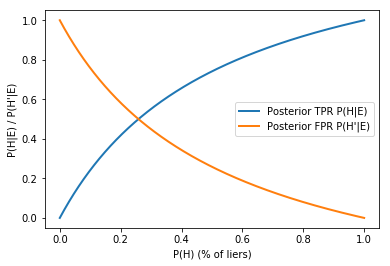

In [49]:
# Let's test different hypothesis
vPrH = np.arange(0.0, 1.0, 0.00001)
vfunc = np.vectorize(posterior)
vPrHE = vfunc(PrEH, vPrH, PrEnH) # posterior of true positives
vPrnHE = 1-vPrHE # posterior of false positives

fig, ax = plt.subplots()
ax.plot(vPrH, vPrHE, '-', lw=2, color='tab:blue')
ax.plot(vPrH, vPrnHE, '-', lw=2, color='tab:orange')
plt.xlabel("P(H) (% of liers)")
plt.ylabel("P(H|E) / P(H'|E)")
plt.legend(["Posterior TPR P(H|E)", "Posterior FPR P(H'|E)"])
#plt.title("Bayesian evaluation of performance")


We can annotate a specific hypothesis. 

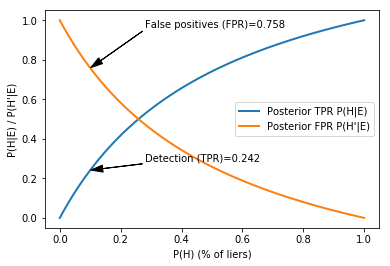

In [50]:
i = 10000
ax.annotate('Detection (TPR)={:.3f}'.format( vPrHE[i] ),
            xy=(vPrH[i], vPrHE[i]), xycoords='data',
            xytext=(vPrH[i]+0.2, vPrHE[i]+0.1), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.01, width=0.05, headwidth=7),
            horizontalalignment='left', verticalalignment='top')

ax.annotate('False positives (FPR)={:.3f}'.format( vPrnHE[i] ),
            xy=(vPrH[i], vPrnHE[i]), xycoords='data',
            xytext=(vPrH[i]+0.2, vPrnHE[i]+0.2), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.01, width=0.05, headwidth=7),
            horizontalalignment='left', verticalalignment='top')
fig

## References: 
[1] BetterExplained, [An Intuitive (and Short) Explanation of Bayes’ Theorem](https://betterexplained.com/articles/an-intuitive-and-short-explanation-of-bayes-theorem/)

[2] Countbayesie.com, [Han Solo and Bayesian Priors](https://www.countbayesie.com/blog/2015/2/18/hans-solo-and-bayesian-priors)

[3] Wikipedia, [Base rate fallacy](https://en.wikipedia.org/wiki/Bayesian_inference)

[4] Wikipedia, [Bayesian inference](https://en.wikipedia.org/wiki/Base_rate_fallacy)

[4] Vera Wilde, [Refugee screening: a brief introduction (and a request for equipment)](http://www.scq.ubc.ca/refugee-screening-a-brief-introduction-and-a-request-for-equipment/)

[5] OrShea, James, Keeley Crockett, Wasiq Khan, Philippos Kindynis, Athos Antoniades, and Georgios Boultadakis. 2018. ‘Intelligent Deception Detection through Machine Based Interviewing’. In 2018 International Joint Conference on Neural Networks (IJCNN), 1–8. Rio de Janeiro, Brazil: IEEE. https://doi.org/10.1109/IJCNN.2018.8489392.